<a href="https://colab.research.google.com/github/arasorietnom/BrainMRI-Tumor-CNN-Classifier/blob/main/Brain_Tumor_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor Classifier using CNN**

This dataset contains 155 MRI images of brain tumors (cases) and 98 healthy and other images (controls).

The dataset can be found under (https://https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection).

*Disclaimer: The images itself might pose a slight quality deficit for the "healthy category".*

In [295]:
import glob
import os
import sys
from zipfile import ZipFile
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import BatchNormalization, Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-Processing

1) Import and segment dataset

In [3]:
from google.colab import files

# Kaggle API key upload
uploaded = files.upload()

# Print uploaded file details
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# placing Kaggle API key to correct directory
!mkdir -p ~/.kaggle
!cp {fn} ~/.kaggle/
!chmod 600 ~/.kaggle/{fn}

# downloading dataset using Kaggle API
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

Saving Brain tumor tutorial.zip to Brain tumor tutorial.zip
User uploaded file "Brain tumor tutorial.zip" with length 15828590 bytes
cp: cannot stat 'Brain': No such file or directory
cp: cannot stat 'tumor': No such file or directory
cp: cannot stat 'tutorial.zip': No such file or directory
chmod: cannot access '/root/.kaggle/Brain': No such file or directory
chmod: cannot access 'tumor': No such file or directory
chmod: cannot access 'tutorial.zip': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
 79% 12.0M/15.1M [00:00<00:00, 22.8MB/s]
100% 15.1M/15.1M [00:00<00:00, 17.1MB/s]


In [47]:
from zipfile import ZipFile
file_name = "/content/brain-mri-images-for-brain-tumor-detection.zip"
with ZipFile(file_name,'r') as zip:
    zip.extractall()
    print('Done')

Done


In [48]:
import os

print("Current working directory:", os.getcwd())
print("Files in 'yes' directory:", os.listdir('/content/yes'))
print("Files in 'no' directory:", os.listdir('/content/no'))


Current working directory: /content
Files in 'yes' directory: ['Y185.jpg', 'Y66.JPG', 'Y65.JPG', 'Y247.JPG', 'Y85.JPG', 'Y22.jpg', 'Y187.jpg', 'Y69.jpg', 'Y249.JPG', 'Y111.JPG', 'Y244.JPG', 'Y10.jpg', 'Y148.JPG', 'Y62.jpg', 'Y38.jpg', 'Y18.JPG', 'Y248.JPG', 'Y33.jpg', 'Y252.jpg', 'Y153.jpg', 'Y162.jpg', 'Y16.JPG', 'Y29.jpg', 'Y86.JPG', 'Y116.JPG', 'Y81.jpg', 'Y92.png', 'Y55.jpg', 'Y114.JPG', 'Y46.jpg', 'Y103.jpg', 'Y184.JPG', 'Y253.JPG', 'Y112.JPG', 'Y27.jpg', 'Y107.jpg', 'Y52.jpg', 'Y183.jpg', 'Y42.jpg', 'Y71.JPG', 'Y54.jpg', 'Y108.jpg', 'Y104.jpg', 'Y157.JPG', 'Y193.JPG', 'Y90.jpg', 'Y73.jpg', 'Y14.jpg', 'Y58.JPG', 'Y254.jpg', 'Y24.jpg', 'Y41.jpg', 'Y31.jpg', 'Y45.JPG', 'Y95.jpg', 'Y195.JPG', 'Y170.JPG', 'Y255.JPG', 'Y4.jpg', 'Y159.JPG', 'Y164.JPG', 'Y251.JPG', 'Y256.JPG', 'Y188.jpg', 'Y92.jpg', 'Y78.jpg', 'Y36.JPG', 'Y194.jpg', 'Y1.jpg', 'Y101.jpg', 'Y180.jpg', 'Y243.JPG', 'Y32.jpg', 'Y246.JPG', 'Y61.jpg', 'Y34.jpg', 'Y35.jpg', 'Y169.jpg', 'Y167.JPG', 'Y17.jpg', 'Y13.jpg', 'Y9.jpg',

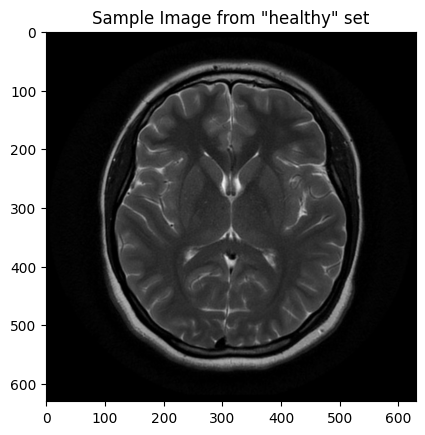

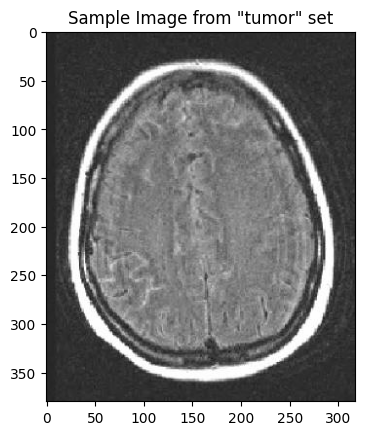

In [49]:
# directory paths for healthy (no) and tumor (yes) images
no_dir = '/content/no'
yes_dir = '/content/yes'

# loading first image from 'no' folder (healthy)
healthy_images = os.listdir(no_dir)
if healthy_images:
    img_path = os.path.join(no_dir, healthy_images[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(img)
    plt.title('Sample Image from "healthy" set')
    plt.show()
else:
    print("No images found in 'no' folder.")

# loading first image from 'yes' folder (tumor)
tumor_images = os.listdir(yes_dir)
if tumor_images:
    img_path = os.path.join(yes_dir, tumor_images[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(img)
    plt.title('Sample Image from "tumor" set')
    plt.show()
else:
    print("No images found in 'yes' folder.")


In [50]:
tumor = []
for f in glob.iglob(os.path.join(yes_dir, '*.jpg')):
    # size standardization
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img) ## OpenCV reads images in BGR format -> convert to RGB
    img = cv2.merge([r,g,b])
    tumor.append(img)

healthy = []
for f in glob.iglob(os.path.join(no_dir, '*.jpg')):
    # size standardization
    img = cv2.imread(f)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img) ## OpenCV reads images in BGR format -> convert to RGB
    img = cv2.merge([r,g,b])
    healthy.append(img)

In [51]:
def __init__(self, image_dir, label_dir):
    self.images = load_images_from_directory(image_dir)
    self.labels = load_labels_from_directory(label_dir)
    print(f"Loaded {len(self.images)} images and {len(self.labels)} labels")

2) Np array image conversion

In [52]:
# segmented arrays
healthy = np.array(healthy)
tumor = np.array(tumor)

In [53]:
  ## check tumor array
tumor.shape

(86, 128, 128, 3)

In [54]:
  ## check healthy array
healthy.shape

(85, 128, 128, 3)

In [55]:
# concatenate arrays
all = np.concatenate((healthy, tumor))

In [56]:
  ## check all array
all.shape

(171, 128, 128, 3)

In [57]:
np.random.choice(10, 5, replace=False) #random Indices for Image selection

array([0, 8, 3, 2, 6])

# Visualizing Brain MRI Images

In [18]:
# dimensions
def plot_random(healthy, tumor, num=6):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
# image loops
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

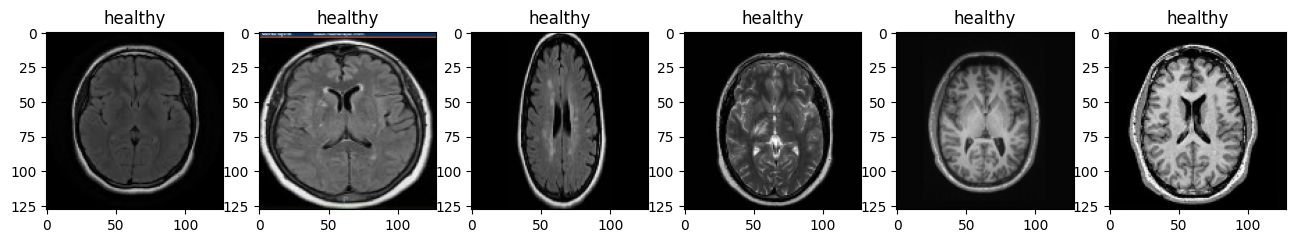

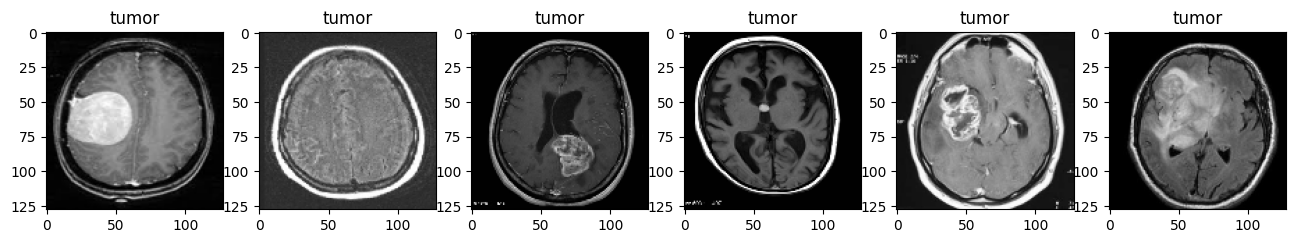

In [19]:
plot_random(healthy, tumor)

In [20]:
## Optional: checking more sample images
# dimensions
def plot_random(healthy, tumor, num=20):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]
# image loops
    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

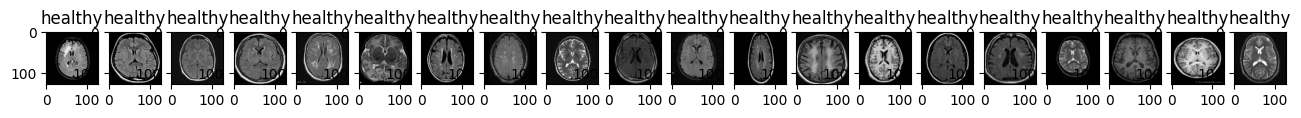

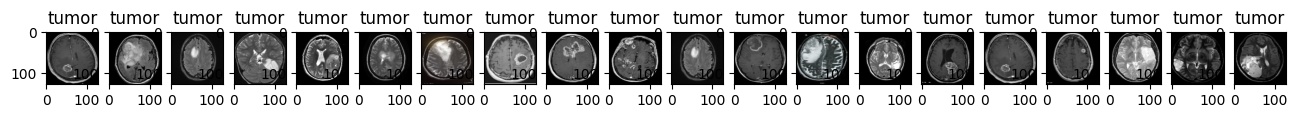

In [21]:
plot_random(healthy, tumor)

# Image and Class Pre-Processing

In [165]:
from torch.utils.data import Dataset
import numpy as np
import cv2
import glob
import torch

In [166]:
class Dataset(object):

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

In [195]:
class MRI(Dataset):
    def __init__(self, yes_dir, no_dir):
        # Load images from directories
        self.tumor_images, self.tumor_labels = self.load_images(yes_dir, label=1)  # Tumor images
        self.healthy_images, self.healthy_labels = self.load_images(no_dir, label=0)  # Healthy images

        # Combine tumor and healthy images into a single dataset
        self.images = np.concatenate((self.tumor_images, self.healthy_images), axis=0)
        self.labels = np.concatenate((self.tumor_labels, self.healthy_labels))

        # Normalizing images
        self.normalize()

    def load_images(self, directory, label):
        images = []
        labels = []
        # '*.jpg' includes all JPEG images in the directory
        for filepath in glob.glob(f"{directory}/*.jpg"):
            img = cv2.imread(filepath)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # resize images
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB
                images.append(img)
                labels.append(int(label))  # ensure label is an integer
        return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int64) #image=float32; label=int64!

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image_tensor = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        label_tensor = torch.tensor(label, dtype=torch.int64)
        return {'image': image_tensor, 'label': label_tensor}

    def normalize(self):
        if self.images.size > 0:
            self.images = self.images / 255.0
        else:
            print("No images to normalize.")

# Usage example
# Directory usage
yes_dir = '/content/yes'
no_dir = '/content/no'
mri_dataset = MRI(yes_dir, no_dir)

In [196]:
mri = mri_dataset  # Optional aliasing

In [197]:
len(mri) #check

171

# Dataloader for Iterations

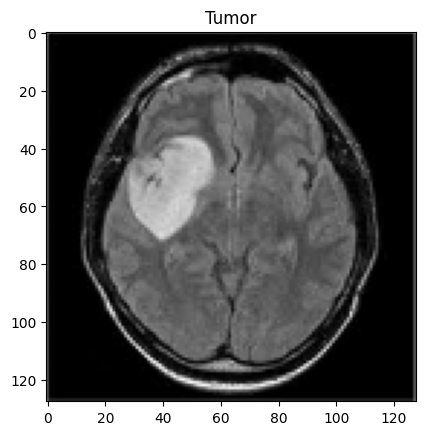

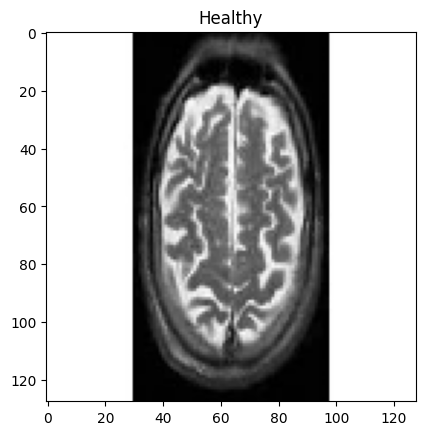

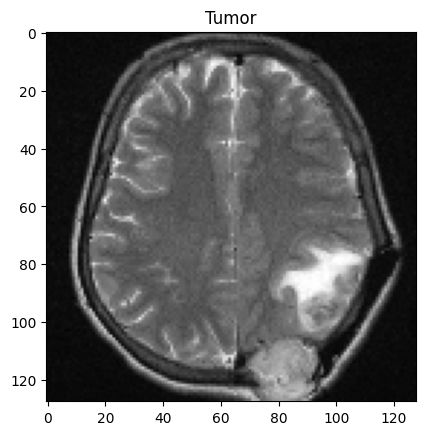

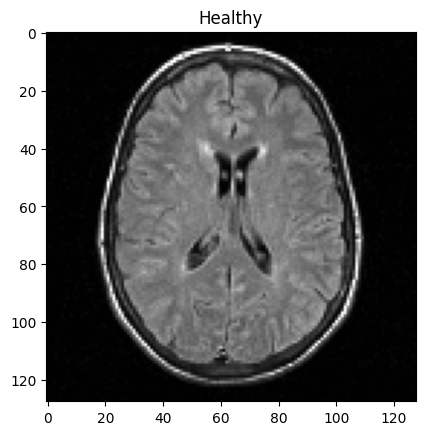

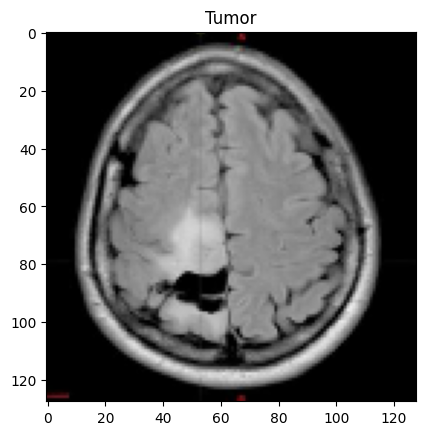

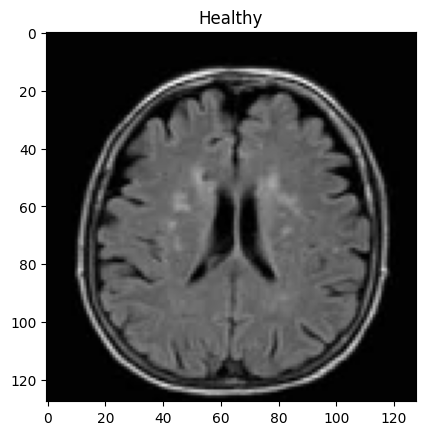

In [201]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# mapping label indices to names
names = {0: 'Healthy', 1: 'Tumor'}

# Create dataloader
dataloader = DataLoader(mri_dataset, batch_size=1, shuffle=True)

# Iterating through the dataloader
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()  # Squeeze removes batch dimension
    label = sample['label'].item()  # Extract scalar value
    plt.imshow(img.permute(1, 2, 0))  # Permute to put channel last for plotting
    plt.title(names[label])
    plt.show()
    if i == 5:
        break
else:
    print("The dataset is empty.")

In [202]:
print(type(mri_dataset))
print(len(mri_dataset))
if hasattr(mri_dataset, '__getitem__'):
    print(mri_dataset[0])  # checking first item to see if data is loaded correctly

<class '__main__.MRI'>
171
{'image': tensor([[[0.1569, 0.1569, 0.1569,  ..., 0.2000, 0.1647, 0.1882],
         [0.1608, 0.1608, 0.1529,  ..., 0.1882, 0.1882, 0.1882],
         [0.1569, 0.1608, 0.1490,  ..., 0.1961, 0.1922, 0.1725],
         ...,
         [0.1569, 0.1490, 0.1608,  ..., 0.1922, 0.1882, 0.1882],
         [0.1490, 0.1647, 0.1569,  ..., 0.1647, 0.1765, 0.1882],
         [0.1490, 0.1608, 0.1490,  ..., 0.1686, 0.1765, 0.1804]],

        [[0.1569, 0.1569, 0.1569,  ..., 0.2000, 0.1647, 0.1882],
         [0.1608, 0.1608, 0.1529,  ..., 0.1882, 0.1882, 0.1882],
         [0.1569, 0.1608, 0.1490,  ..., 0.1961, 0.1922, 0.1725],
         ...,
         [0.1569, 0.1490, 0.1608,  ..., 0.1922, 0.1882, 0.1882],
         [0.1490, 0.1647, 0.1569,  ..., 0.1647, 0.1765, 0.1882],
         [0.1490, 0.1608, 0.1490,  ..., 0.1686, 0.1765, 0.1804]],

        [[0.1569, 0.1569, 0.1569,  ..., 0.2000, 0.1647, 0.1882],
         [0.1608, 0.1608, 0.1529,  ..., 0.1882, 0.1882, 0.1882],
         [0.1569, 0.1

# CNN model creation

In [204]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

In [218]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False, drop_last=True)

GPU

In [245]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.7693, 0.9340, 0.5475, 0.2004, 0.3136, 0.7237, 0.1334, 0.6712, 0.1819,
        0.5100], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.7693, 0.9340, 0.5475, 0.2004, 0.3136, 0.7237, 0.1334, 0.6712, 0.1819,
        0.5100], device='cuda:0') torch.float32 <class 'torch.Tensor'> torch.cuda.FloatTensor
tensor([0.5918, 0.8723, 0.2998, 0.0401, 0.0984, 0.5237, 0.0178, 0.4505, 0.0331,
        0.2601], device='cuda:0')


CNN model architecture

In [219]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # defining convolutional layers
        self.cnn_model = nn.Sequential(
            # 1st convolutional layer: input channels = 3, output channels = 6, kernel size = 5x5
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
            nn.Tanh(),  # hyperbolic tangent activation function
            nn.AvgPool2d(kernel_size=2, stride=5),  # average pooling with kernel size 2x2 and stride 5

            # 2nd convolutional layer: input channels = 6, output channels = 16, kernel size = 5x5
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.Tanh(),  # hyperbolic tangent activation function
            nn.AvgPool2d(kernel_size=2, stride=5)  # average pooling with kernel size 2x2 and stride 5
        )

        # Define fully connected layers
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),  # fully connected layer with 256 input features and 120 output features
            nn.Tanh(),  # hyperbolic tangent activation function
            nn.Linear(in_features=120, out_features=84),  # fully connected layer with 120 input features and 84 output features
            nn.Tanh(),  # hyperbolic tangent activation function
            nn.Linear(in_features=84, out_features=1)  # fully connected layer with 84 input features and 1 output feature
        )

    def forward(self, x):
        # forward pass through the convolutional layers
        x = self.cnn_model(x)
        # flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)
        # forward pass through the fully connected layers
        x = self.fc_model(x)
        # sigmoid activation function to get probabilities
        x = F.sigmoid(x)

        return x

In [220]:
model = CNN()

In [221]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [222]:
model.cnn_model[0].weight #weights of the first convolutional layer in your model

Parameter containing:
tensor([[[[ 1.0253e-01, -6.9641e-02, -1.0761e-01, -6.6248e-02, -7.2290e-03],
          [-2.5001e-02,  9.3076e-03, -3.6457e-03, -6.3451e-03, -8.3588e-02],
          [-1.1514e-01,  2.0490e-03, -1.6723e-02, -3.0474e-02, -1.3815e-02],
          [ 3.7547e-02, -8.5326e-02, -5.5801e-02, -5.9267e-02, -2.1469e-02],
          [ 1.1091e-01, -2.6630e-03, -4.6031e-02,  6.2753e-02,  9.5369e-02]],

         [[ 9.2772e-02,  2.7636e-02,  9.5018e-02, -5.9667e-02, -8.8333e-02],
          [ 1.1405e-01,  8.0224e-02,  2.4156e-02, -2.4626e-02, -2.6734e-02],
          [ 1.4308e-02,  9.2663e-02, -7.0341e-02,  7.9233e-02,  6.8134e-02],
          [ 3.3576e-02, -8.2829e-02, -2.2147e-02, -6.7842e-02, -5.7229e-02],
          [-7.7577e-02, -1.0621e-01,  5.3940e-02,  2.3206e-02, -5.0363e-02]],

         [[-6.6029e-03, -5.8334e-02,  3.0112e-02,  8.7719e-02, -5.7431e-02],
          [-1.2271e-02,  5.2373e-02, -2.8079e-02, -4.6152e-02, -1.1059e-01],
          [-1.4734e-03,  9.5068e-02, -5.4643e-02, 

In [223]:
model.cnn_model[0].weight.shape #6 filters, 3 channels

torch.Size([6, 3, 5, 5])

Evaluate CNN model

In [224]:
mri_dataset = MRI(yes_dir, no_dir)
mri_dataset.normalize()
device = torch.device('cuda:0')
model = CNN().to(device)

In [225]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False, drop_last=True)

In [248]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [249]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [250]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [251]:
accuracy_score(y_true, threshold(outputs))

0.4625

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

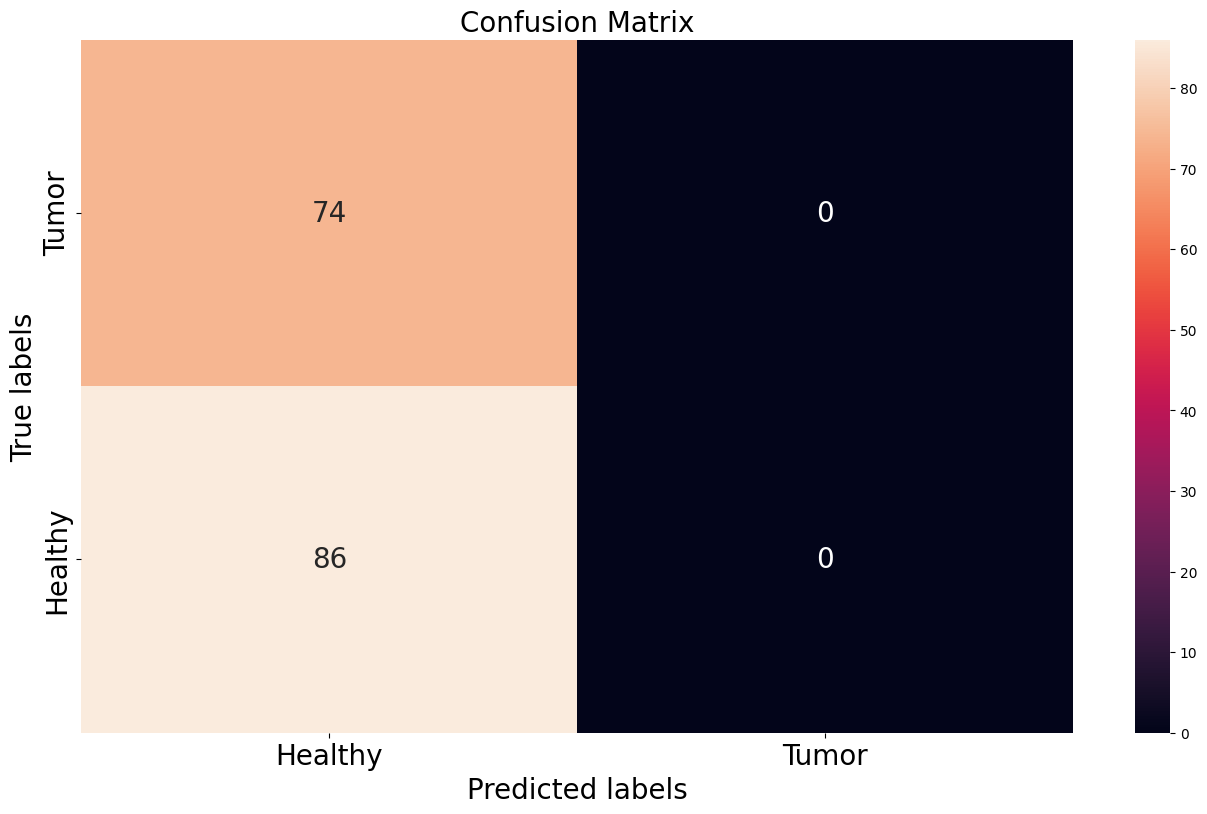

In [252]:
#CONFUSION MATRIX
plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

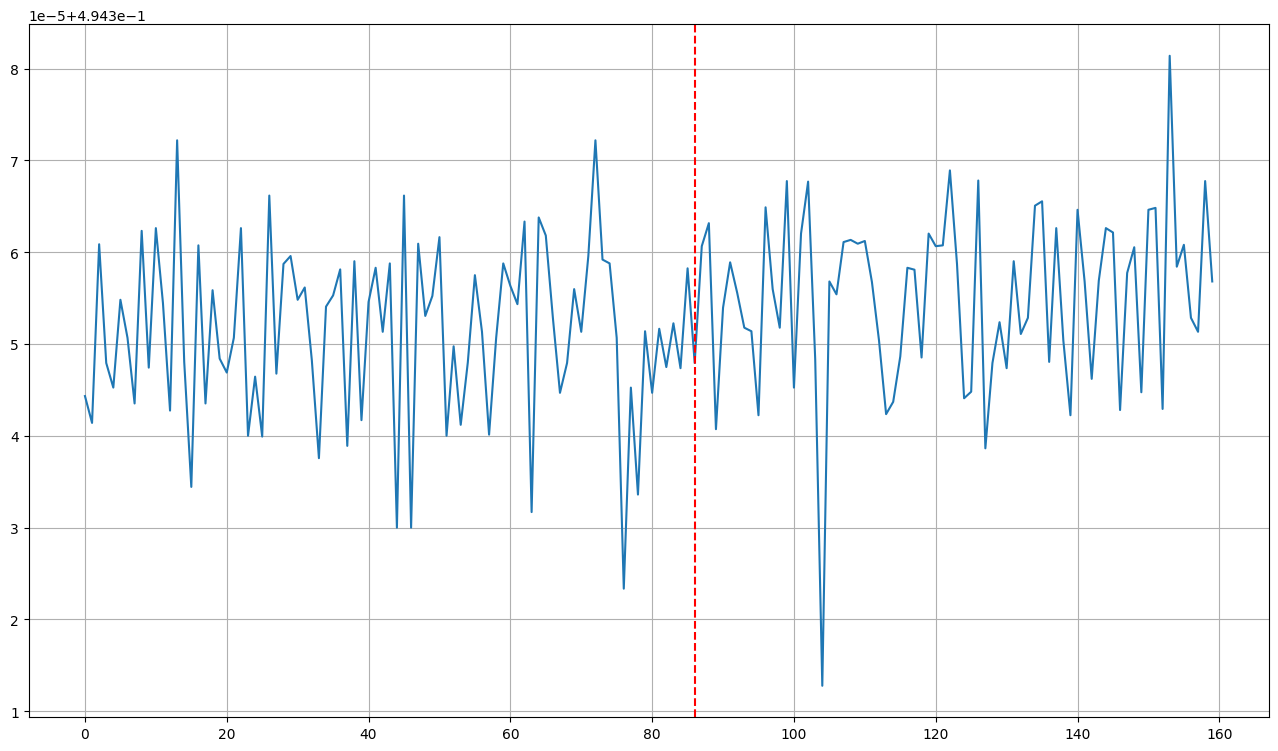

In [253]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

Training the novel model (it is not performing well yet...)

In [254]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

Training Loop

In [267]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device).float()
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.693468
Train Epoch: 20	Loss: 0.684635
Train Epoch: 30	Loss: 0.684415
Train Epoch: 40	Loss: 0.684149
Train Epoch: 50	Loss: 0.683696
Train Epoch: 60	Loss: 0.683166
Train Epoch: 70	Loss: 0.682582
Train Epoch: 80	Loss: 0.681940
Train Epoch: 90	Loss: 0.681232
Train Epoch: 100	Loss: 0.680441
Train Epoch: 110	Loss: 0.679552
Train Epoch: 120	Loss: 0.678547
Train Epoch: 130	Loss: 0.677403
Train Epoch: 140	Loss: 0.676093
Train Epoch: 150	Loss: 0.674587
Train Epoch: 160	Loss: 0.672848
Train Epoch: 170	Loss: 0.670833
Train Epoch: 180	Loss: 0.668492
Train Epoch: 190	Loss: 0.665768
Train Epoch: 200	Loss: 0.662600
Train Epoch: 210	Loss: 0.658922
Train Epoch: 220	Loss: 0.654675
Train Epoch: 230	Loss: 0.649811
Train Epoch: 240	Loss: 0.644311
Train Epoch: 250	Loss: 0.638206
Train Epoch: 260	Loss: 0.631595
Train Epoch: 270	Loss: 0.624657
Train Epoch: 280	Loss: 0.617644
Train Epoch: 290	Loss: 0.610847
Train Epoch: 300	Loss: 0.604534
Train Epoch: 310	Loss: 0.598892
Train Epoch: 320	

In [288]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [289]:
accuracy_score(y_true, threshold(outputs))

0.6842105263157895

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

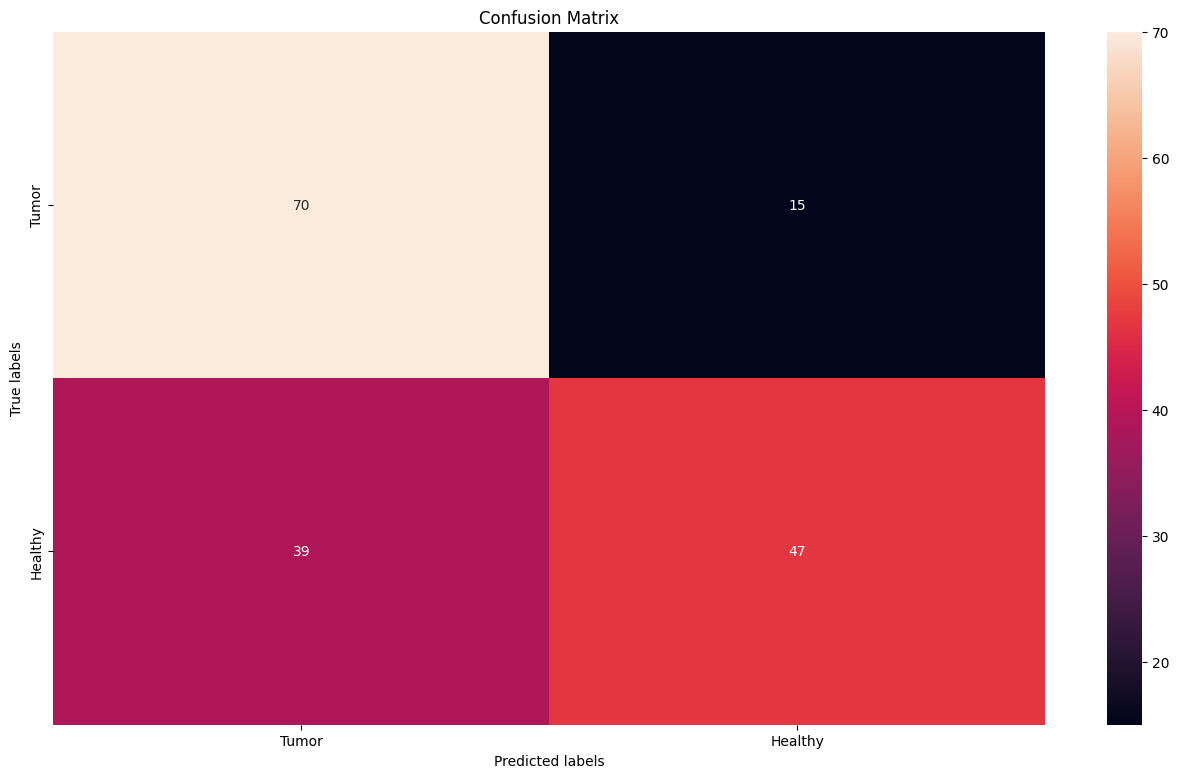

In [290]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))
#CONFUSION MATRIX
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

**Analysis of the Confusion Matrix:**

*   True Positives (Top Left, 70): The model correctly identified 70 'Tumor' cases as 'Tumor'.
*   True Negatives (Bottom Right, 47): The model correctly identified 47 'Healthy' cases as 'Healthy'.
*   False Positives (Bottom Left, 39): The model incorrectly identified 39 'Healthy' cases as 'Tumor'.
*   False Negatives (Top Right, 15): The model incorrectly identified 15 'Tumor' cases as 'Healthy'.

While the model has learned to some extent to differentiate between the classes, it's not yet finely tuned (balanced error types).

**Sensitivity and Specificity:**

Sensitivity (also called the true positive rate, or the recall for the 'Tumor' class) is 70/(70+15)≈82.4%. This indicates the model's ability to correctly identify 'Tumor' cases.

Specificity (true negative rate for the 'Healthy' class) is 47/(47+39)≈54.7%. This shows the model's ability to correctly identify 'Healthy' cases.

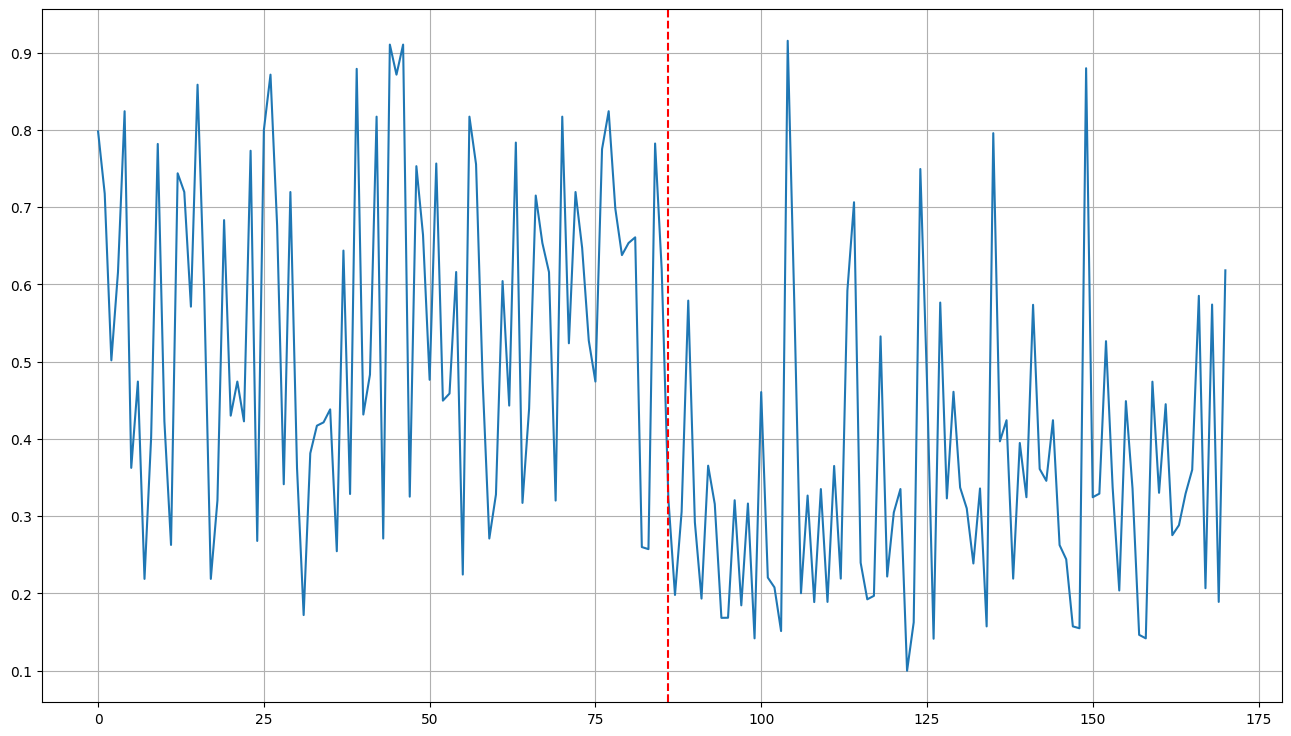

In [271]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()